In [1]:
from pconv_unet import PartialConvUNet
import torch


In [2]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [3]:
model = PartialConvUNet().to(device)


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
from datamodule import InpaintingDataset

ds = InpaintingDataset(
    images_dir='../image_generation/generated/backgrounds/',
    masks_dir='../image_generation/generated/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
)

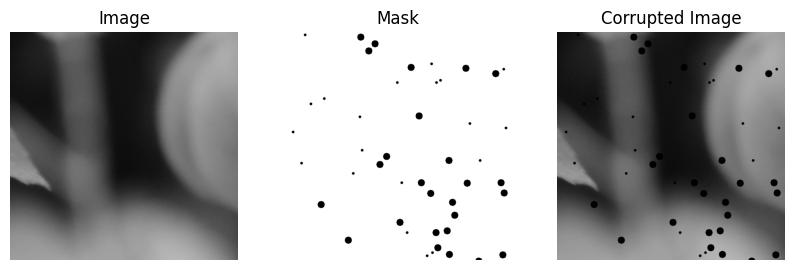

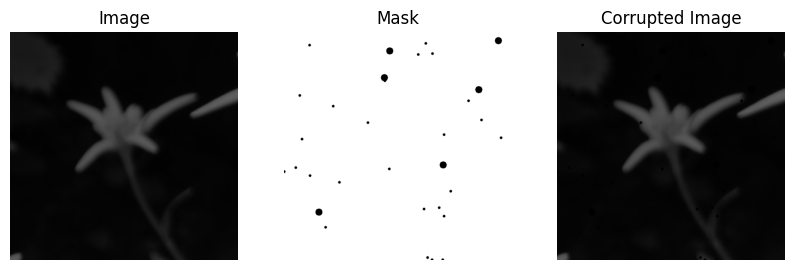

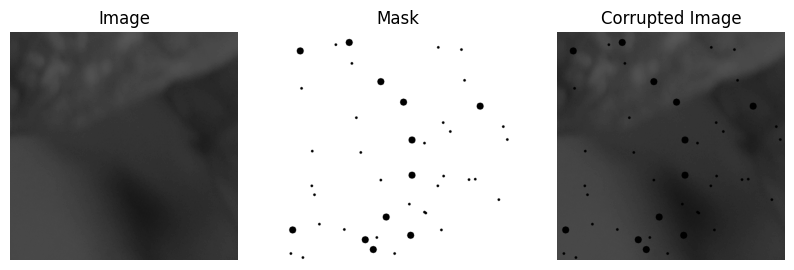

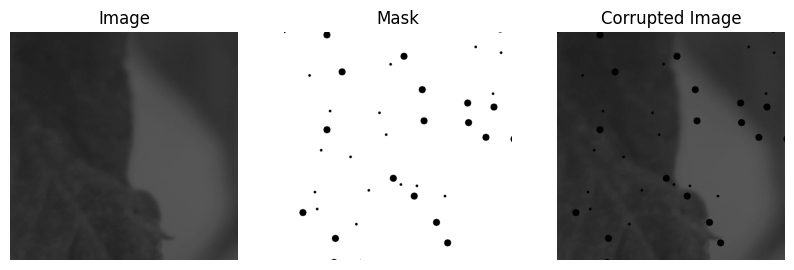

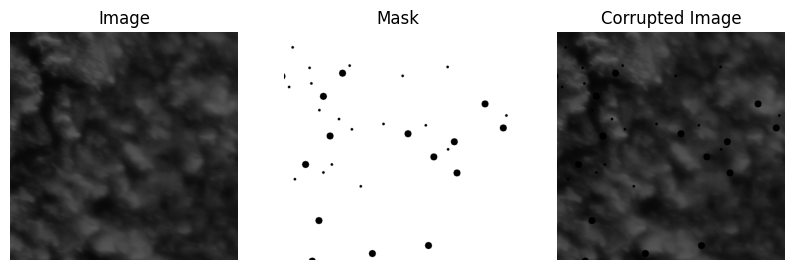

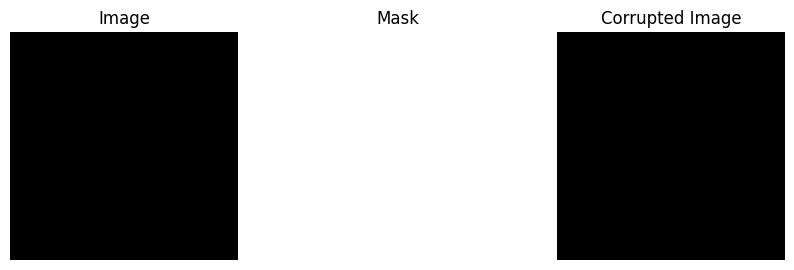

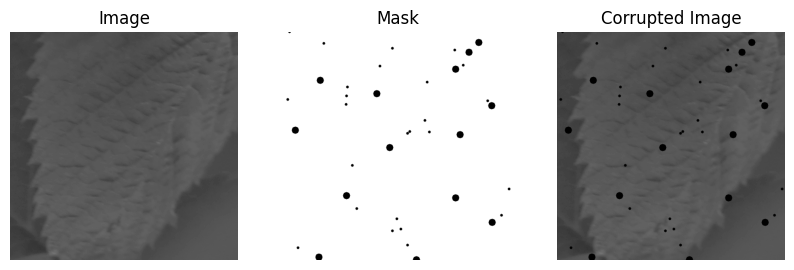

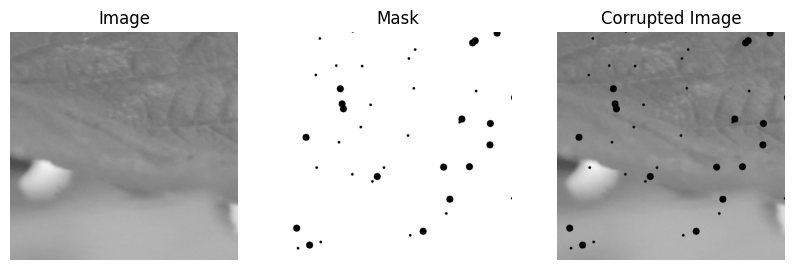

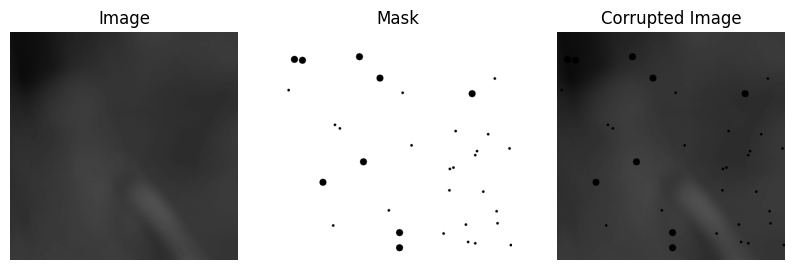

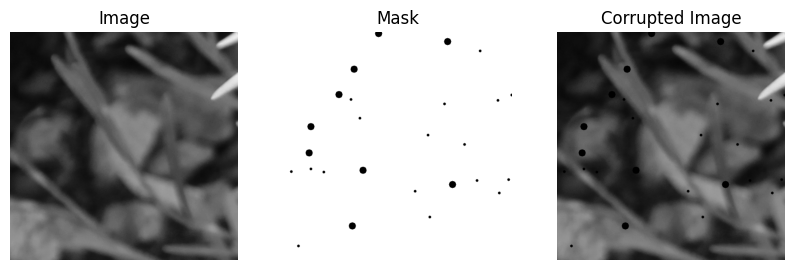

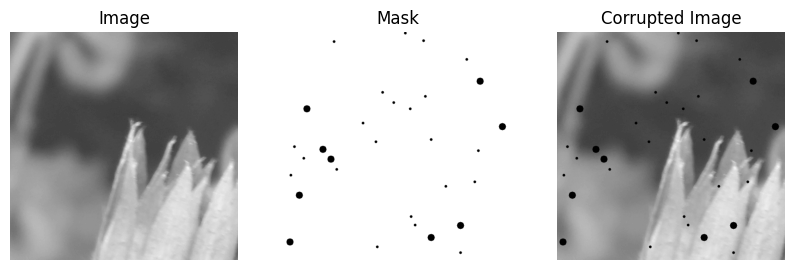

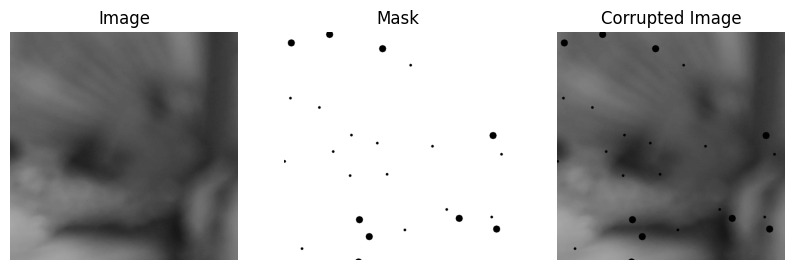

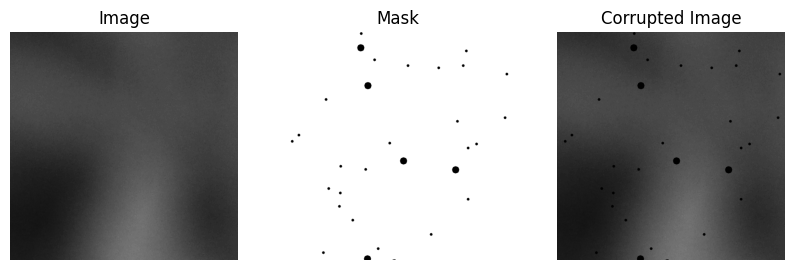

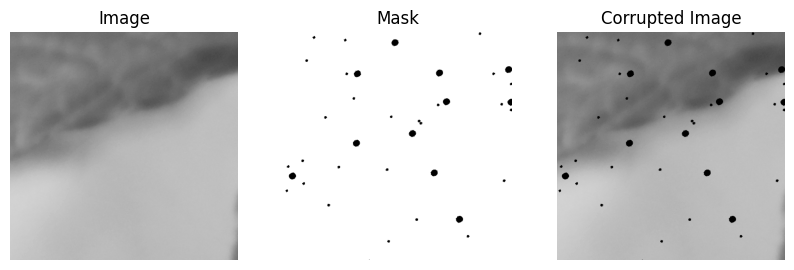

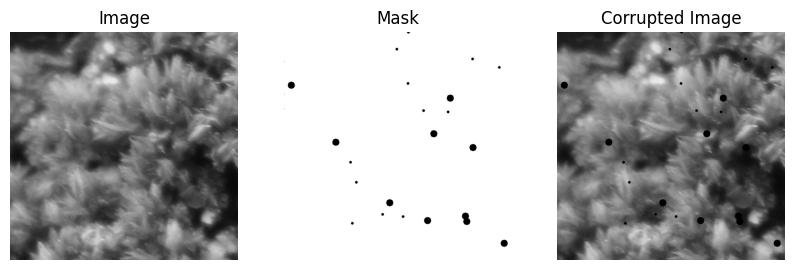

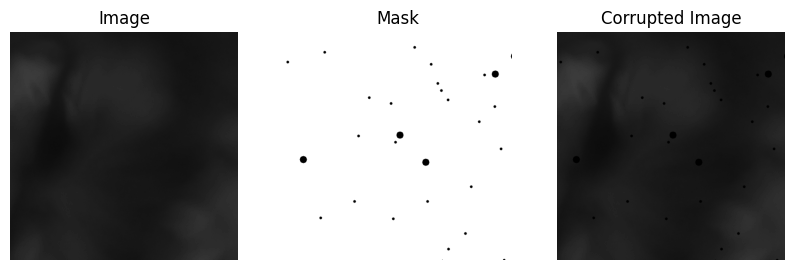

In [6]:
import matplotlib.pyplot as plt
for im, mask in ds:
    cor = im * (mask)
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Mask')
    axs[2].imshow(cor.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Corrupted Image')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [7]:
from datamodule import InpaintingDataModule
dm = InpaintingDataModule(
    train_images_dir='../image_generation/generated/backgrounds/',
    train_masks_dir='../image_generation/generated/masks/',
    val_images_dir='../image_generation/generated/backgrounds/',
    val_masks_dir='../image_generation/generated/masks/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(512, 512),
    batch_size=2,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [8]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


In [9]:
model = PartialConvUNet().to(device)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2


In [11]:

# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in train_loader:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * mask
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        
        # Calculate loss (only for the masked regions)
        masked_diff = (output - original) * (1 - mask)
        loss = (masked_diff ** 2).sum() / (1 - mask).sum()

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0607
Epoch 2/10, Loss: 0.0412
Epoch 3/10, Loss: 0.0393
Epoch 4/10, Loss: 0.0432
Epoch 5/10, Loss: 0.0343
Epoch 6/10, Loss: 0.0196
Epoch 7/10, Loss: 0.0171
Epoch 8/10, Loss: 0.0198
Epoch 9/10, Loss: 0.0139
Epoch 10/10, Loss: 0.0200


In [12]:

# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in train_loader:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * mask
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        
        # Calculate loss (only for the masked regions)
        masked_diff = (output - original) * (1 - mask)
        loss = (masked_diff ** 2).sum() / (1 - mask).sum()

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.0096
Epoch 2/20, Loss: 0.0117
Epoch 3/20, Loss: 0.0134
Epoch 4/20, Loss: 0.0134
Epoch 5/20, Loss: 0.0180
Epoch 6/20, Loss: 0.0126
Epoch 7/20, Loss: 0.0133
Epoch 8/20, Loss: 0.0113
Epoch 9/20, Loss: 0.0104
Epoch 10/20, Loss: 0.0121
Epoch 11/20, Loss: 0.0135
Epoch 12/20, Loss: 0.0093
Epoch 13/20, Loss: 0.0093
Epoch 14/20, Loss: 0.0117
Epoch 15/20, Loss: 0.0105
Epoch 16/20, Loss: 0.0062
Epoch 17/20, Loss: 0.0077
Epoch 18/20, Loss: 0.0117
Epoch 19/20, Loss: 0.0082
Epoch 20/20, Loss: 0.0130


In [15]:

# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in train_loader:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * mask
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        
        # Calculate loss (only for the masked regions)
        masked_diff = (output - original) * (1 - mask)
        loss = (masked_diff ** 2).sum() / (1 - mask).sum()

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.0086
Epoch 2/20, Loss: 0.0103
Epoch 3/20, Loss: 0.0110
Epoch 4/20, Loss: 0.0078
Epoch 5/20, Loss: 0.0091
Epoch 6/20, Loss: 0.0087
Epoch 7/20, Loss: 0.0104
Epoch 8/20, Loss: 0.0107
Epoch 9/20, Loss: 0.0075
Epoch 10/20, Loss: 0.0095
Epoch 11/20, Loss: 0.0087
Epoch 12/20, Loss: 0.0103
Epoch 13/20, Loss: 0.0068
Epoch 14/20, Loss: 0.0093
Epoch 15/20, Loss: 0.0077
Epoch 16/20, Loss: 0.0068
Epoch 17/20, Loss: 0.0091
Epoch 18/20, Loss: 0.0084
Epoch 19/20, Loss: 0.0086
Epoch 20/20, Loss: 0.0069


In [17]:

# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in train_loader:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * mask
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        
        # Calculate loss (only for the masked regions)
        masked_diff = (output - original) * (1 - mask)
        loss = (masked_diff ** 2).sum() / (1 - mask).sum()

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.0090
Epoch 2/20, Loss: 0.0092
Epoch 3/20, Loss: 0.0071
Epoch 4/20, Loss: 0.0097
Epoch 5/20, Loss: 0.0122
Epoch 6/20, Loss: 0.0054
Epoch 7/20, Loss: 0.0062
Epoch 8/20, Loss: 0.0057
Epoch 9/20, Loss: 0.0101
Epoch 10/20, Loss: 0.0086
Epoch 11/20, Loss: 0.0053
Epoch 12/20, Loss: 0.0079
Epoch 13/20, Loss: 0.0090
Epoch 14/20, Loss: 0.0079
Epoch 15/20, Loss: 0.0121
Epoch 16/20, Loss: 0.0084
Epoch 17/20, Loss: 0.0067
Epoch 18/20, Loss: 0.0083
Epoch 19/20, Loss: 0.0066
Epoch 20/20, Loss: 0.0039


maximum values:  0.7372549176216125 1.0 0.7372549176216125 tensor(0.9575, device='cuda:0') tensor(0.9194, device='cuda:0')
maximum values:  0.3960784375667572 1.0 0.3960784375667572 tensor(0.7370, device='cuda:0') tensor(0.4980, device='cuda:0')
maximum values:  0.41960784792900085 1.0 0.41960784792900085 tensor(0.7874, device='cuda:0') tensor(0.5027, device='cuda:0')
maximum values:  0.9137254953384399 1.0 0.9137254953384399 tensor(0.9108, device='cuda:0') tensor(0.9137, device='cuda:0')
maximum values:  0.7882353067398071 1.0 0.7882353067398071 tensor(0.8412, device='cuda:0') tensor(0.7882, device='cuda:0')
maximum values:  0.7843137383460999 1.0 0.7843137383460999 tensor(0.9310, device='cuda:0') tensor(0.8422, device='cuda:0')
maximum values:  0.8470588326454163 1.0 0.8470588326454163 tensor(0.9809, device='cuda:0') tensor(0.9540, device='cuda:0')
maximum values:  0.9686274528503418 1.0 0.9686274528503418 tensor(0.9299, device='cuda:0') tensor(0.9686, device='cuda:0')


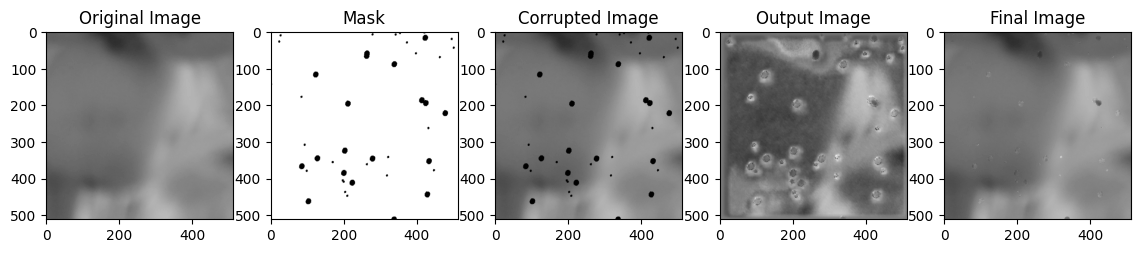

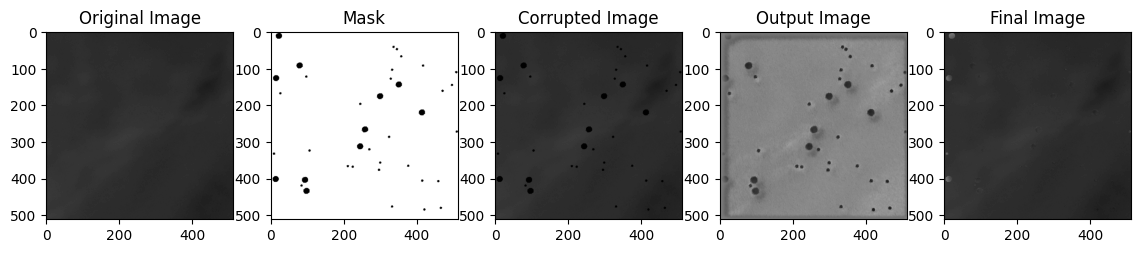

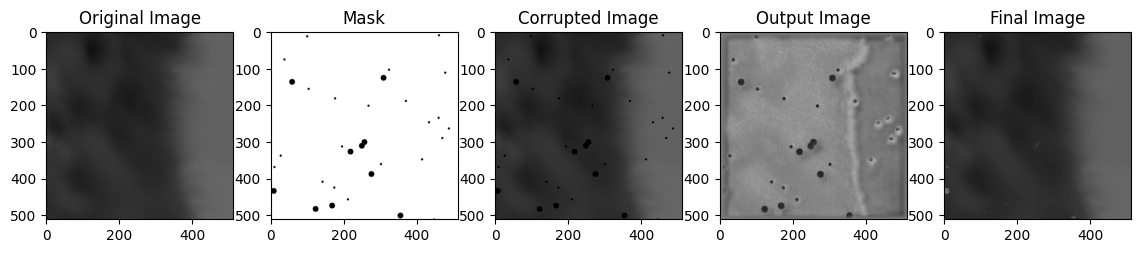

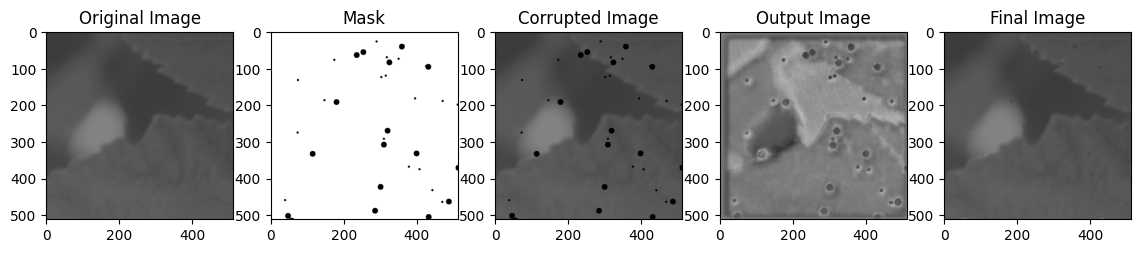

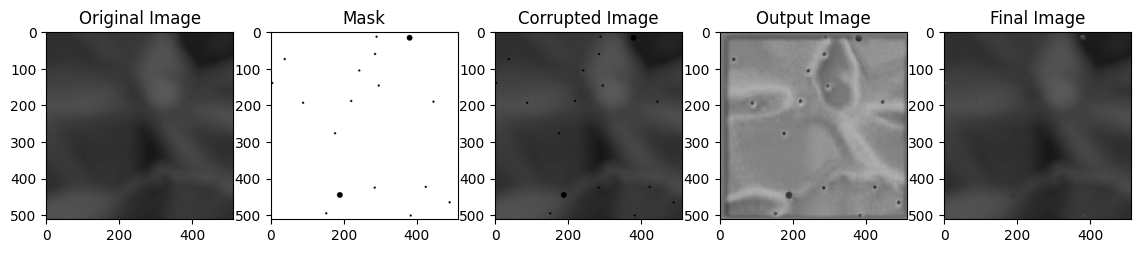

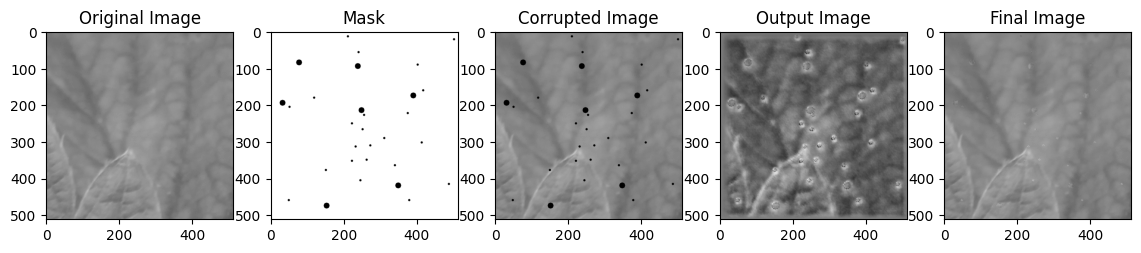

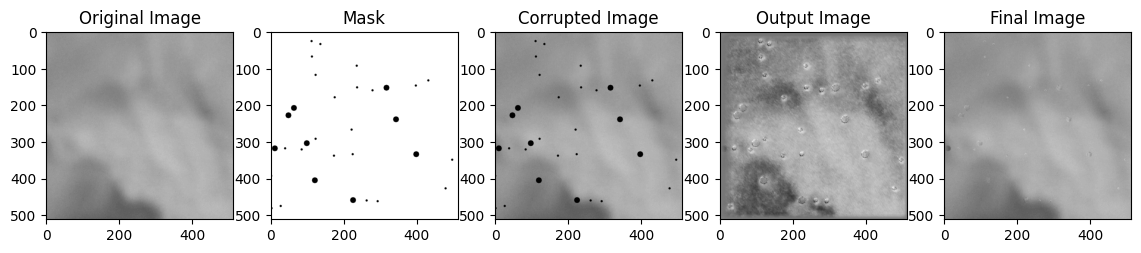

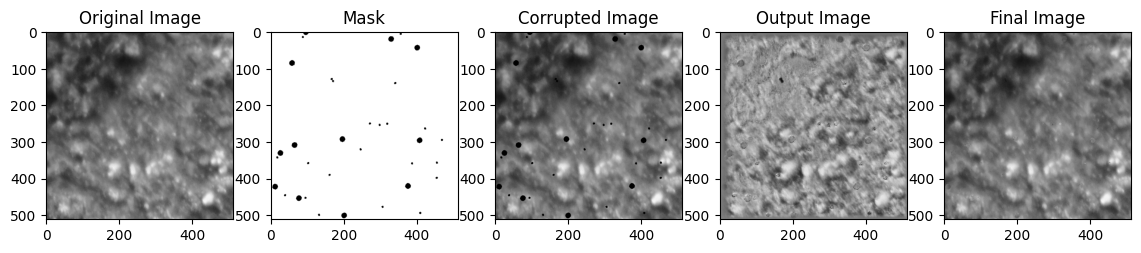

In [18]:
for original, mask in val_loader:
    original = original.to(device)
    mask = mask.to(device)
    corrupted = original * (mask) 
    model.eval()
    with torch.no_grad():
        output = model(corrupted, mask)
    final = output * (1 - mask) + original * (mask)


    print("maximum values: ", torch.max(original).item(), torch.max(mask).item(), torch.max(corrupted).item(), torch.max(output), torch.max(final))
    # plot output 
    fig, axs = plt.subplots(1, 5, figsize=(14, 5))
    axs[0].imshow(original[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask[0].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Mask')
    axs[2].imshow(corrupted[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Corrupted Image')
    axs[3].imshow(output[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[3].set_title('Output Image')
    #final
    axs[4].imshow(final[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[4].set_title('Final Image')
    # save final image
    cv2.imwrite('final.png', final[0].permute(1, 2, 0).squeeze().cpu().numpy() * 255)
    
    



In [19]:
torch.save(model.state_dict(), 'luc2.pth')

In [23]:
import torch
import torch.nn.functional as F

def total_variation(x):
    tv_h = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return tv_h + tv_w

def inpainting_loss(output, gt, mask,
                    lambda_valid=1.0, lambda_hole=6.0, lambda_tv=0.1):
    """
    output: modello (B, C, H, W)
    gt: ground truth (B, C, H, W)
    mask: binary mask (1=buco, 0=valido), (B, 1, H, W)
    """

    valid = mask
    hole = 1 - valid

    l1_valid = F.l1_loss(output * valid, gt * valid)
    l2_hole = F.mse_loss(output * hole, gt * hole)
    tv = total_variation(output)

    loss = lambda_valid * l1_valid + lambda_hole * l2_hole + lambda_tv * tv
    return loss


In [24]:

# Define loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for original, mask in train_loader:
        original = original.to(device)
        mask = mask.to(device)
        corrupted = original * mask
        # Forward pass
        optimizer.zero_grad()
        output = model(corrupted, mask)
        
        loss = inpainting_loss(output, original, mask, 
                               lambda_valid=1.0, lambda_hole=6.0, lambda_tv=0.2)
        
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.2639
Epoch 2/20, Loss: 0.2396
Epoch 3/20, Loss: 0.2288
Epoch 4/20, Loss: 0.2629
Epoch 5/20, Loss: 0.2470
Epoch 6/20, Loss: 0.2242
Epoch 7/20, Loss: 0.2410
Epoch 8/20, Loss: 0.2216
Epoch 9/20, Loss: 0.2180
Epoch 10/20, Loss: 0.2120
Epoch 11/20, Loss: 0.2467
Epoch 12/20, Loss: 0.1953
Epoch 13/20, Loss: 0.1446
Epoch 14/20, Loss: 0.1892
Epoch 15/20, Loss: 0.1675
Epoch 16/20, Loss: 0.1854
Epoch 17/20, Loss: 0.1738
Epoch 18/20, Loss: 0.1958
Epoch 19/20, Loss: 0.1822
Epoch 20/20, Loss: 0.1764


maximum values:  0.7176470756530762 1.0 0.7176470756530762 tensor(0.9950, device='cuda:0') tensor(0.9259, device='cuda:0')
maximum values:  0.3176470696926117 1.0 0.3176470696926117 tensor(0.5445, device='cuda:0') tensor(0.4987, device='cuda:0')
maximum values:  0.38823530077934265 1.0 0.38823530077934265 tensor(0.5870, device='cuda:0') tensor(0.5002, device='cuda:0')
maximum values:  1.0 1.0 1.0 tensor(1.0000, device='cuda:0') tensor(1., device='cuda:0')
maximum values:  0.7098039388656616 1.0 0.7098039388656616 tensor(0.9904, device='cuda:0') tensor(0.7098, device='cuda:0')
maximum values:  0.7843137383460999 1.0 0.7843137383460999 tensor(0.9972, device='cuda:0') tensor(0.9505, device='cuda:0')
maximum values:  0.8196078538894653 1.0 0.8196078538894653 tensor(0.9998, device='cuda:0') tensor(0.9982, device='cuda:0')
maximum values:  0.9607843160629272 1.0 0.9607843160629272 tensor(0.9999, device='cuda:0') tensor(0.9963, device='cuda:0')


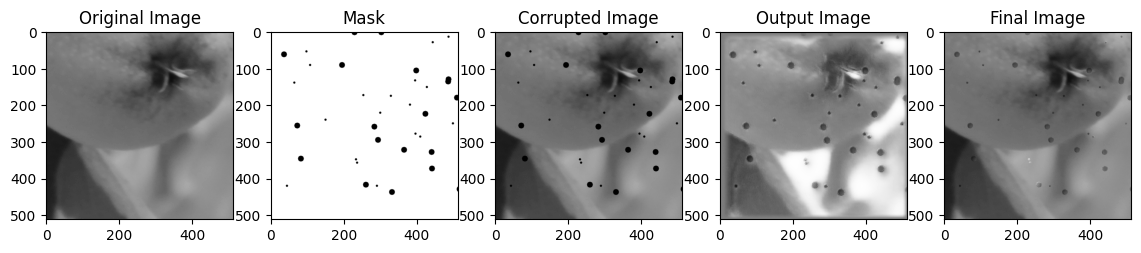

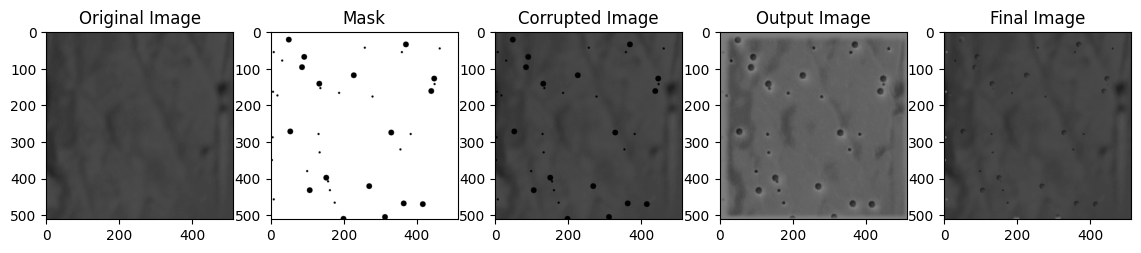

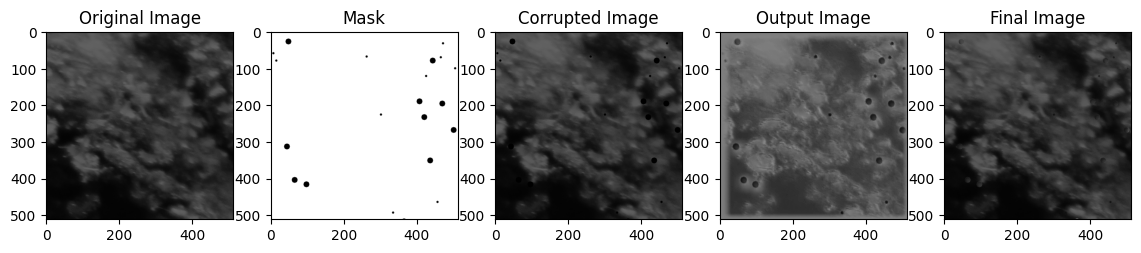

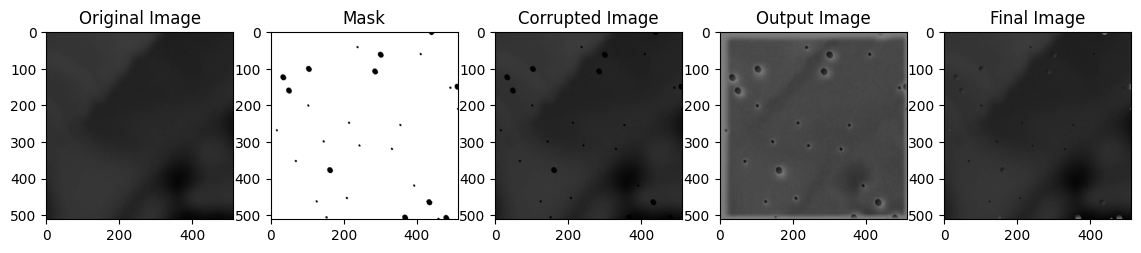

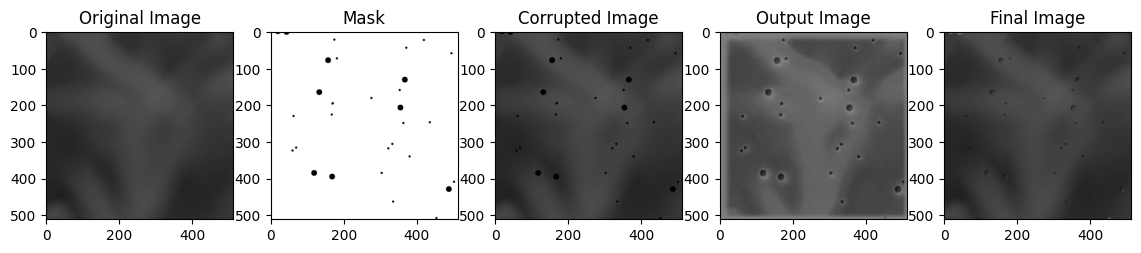

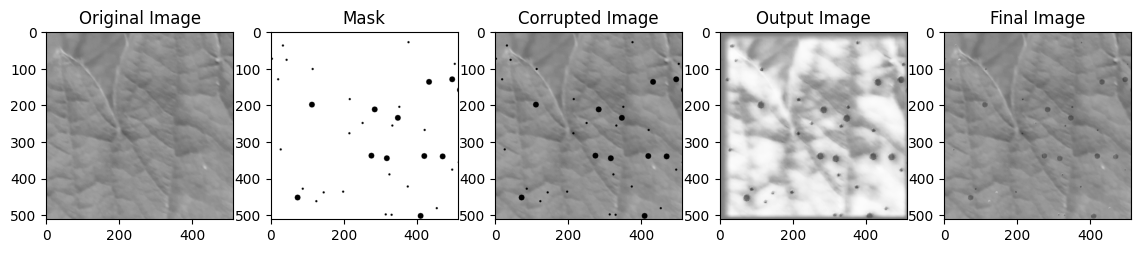

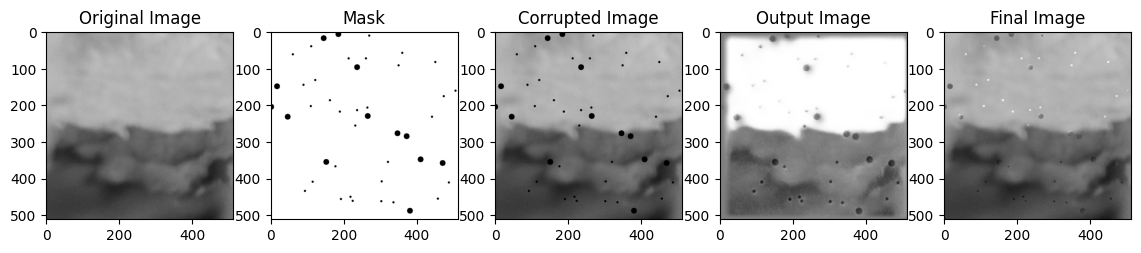

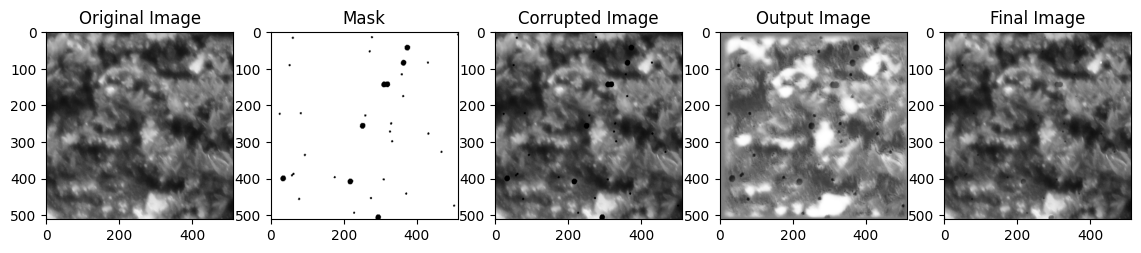

In [25]:
for original, mask in val_loader:
    original = original.to(device)
    mask = mask.to(device)
    corrupted = original * (mask) 
    model.eval()
    with torch.no_grad():
        output = model(corrupted, mask)
    final = output * (1 - mask) + original * (mask)


    print("maximum values: ", torch.max(original).item(), torch.max(mask).item(), torch.max(corrupted).item(), torch.max(output), torch.max(final))
    # plot output 
    fig, axs = plt.subplots(1, 5, figsize=(14, 5))
    axs[0].imshow(original[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask[0].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Mask')
    axs[2].imshow(corrupted[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Corrupted Image')
    axs[3].imshow(output[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[3].set_title('Output Image')
    #final
    axs[4].imshow(final[0].permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axs[4].set_title('Final Image')
    # save final image
    cv2.imwrite('final.png', final[0].permute(1, 2, 0).squeeze().cpu().numpy() * 255)
    
    



worst with this loss